In [1]:
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt

def parse_data(paths):
    result_dict = {}
    dicts = []
    for path in paths:
        with open(path, 'rb') as f:
            dicts.append(pickle.load(f))
    for dict in dicts:
        for key in dict:
            next_entrance = dict[key].reshape([1, -1])
            if key in result_dict:
                result_dict[key] = np.append(result_dict[key], next_entrance, axis=0)
            else:
                result_dict[key] = next_entrance
    return result_dict

def plot_experiment_data(timesteps, experiments, names, plot_name, path=None):
    # create figure and axis objects
    fig, ax = plt.subplots()

    # loop over experiments
    for i, experiment in enumerate(experiments):
        # calculate mean and standard deviation of each time step for this experiment
        mean_data = np.mean(experiment, axis=0)
        std_data = 1 / np.sqrt(experiment.shape[0]) * np.std(experiment, axis=0)

        # plot mean data as a line and shade area between ±1 standard deviation
        ax.plot(timesteps[i], mean_data, '-o', markersize=5, label=names[i])
        ax.fill_between(timesteps[i], mean_data-std_data, mean_data+std_data, alpha=0.3)

    # add labels, title, and legend to the plot
    ax.set_xlabel('Number Sampled Trajectories')
    ax.set_ylabel('Success Rate')
    ax.set_title(plot_name)
    ax.legend()

    if path is not None:
        # create directory if it doesn't exist
        os.makedirs(path, exist_ok=True)
        # save the plot
        plt.savefig(os.path.join(path, plot_name + '.png'))

    # display the plot
    plt.show()

def file_crawler(path, substrings, exclude=[]):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            file_path = os.path.join(root, name)
            if all(s in file_path for s in substrings) and not any(e in file_path for e in exclude):
                result.append(file_path)
    print(f'for path: {path}: {len(result)}')
    return result

def make_plot(paths, includes, excludes, names, plot_name, save_path = None):
    abs_file_path_list = []
    
    for i in range(len(paths)):
        abs_file_path_list.append(file_crawler(path=paths[i], substrings=includes[i], exclude=excludes[i]))
    dicts = []
    
    for result in abs_file_path_list:
        dicts.append(parse_data(paths=result))

    plot_experiment_data(
        timesteps=[result_dict['step'][0] for result_dict in dicts], 
        experiments=[result_dict['success_rate'] for result_dict in dicts],
        names=names,
        plot_name=plot_name,
        path=save_path
        )

for path: /home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-23: 20
for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/: 10


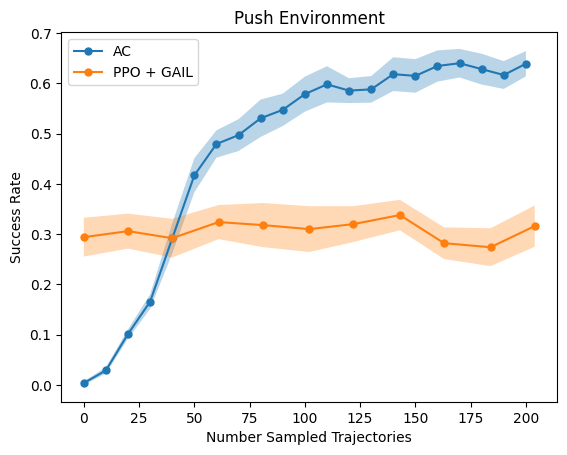

In [4]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-23'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/'

include_ac = ['push', '10','True', 'stats', '2000']
exclude_ac = ['optimize']

include_bl = ['demonstrations_10', 'learner', 'push', 'PPO', '0.0001']
exclude_bl = []


save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, bl_path], 
    includes=[include_ac, include_bl], 
    excludes=[exclude_ac, exclude_bl],
    names=['AC', 'PPO + GAIL'],
    plot_name='Push Environment',
    save_path = None
    )

for path: /home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-23: 20
for path: /home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-23: 20
for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/: 10


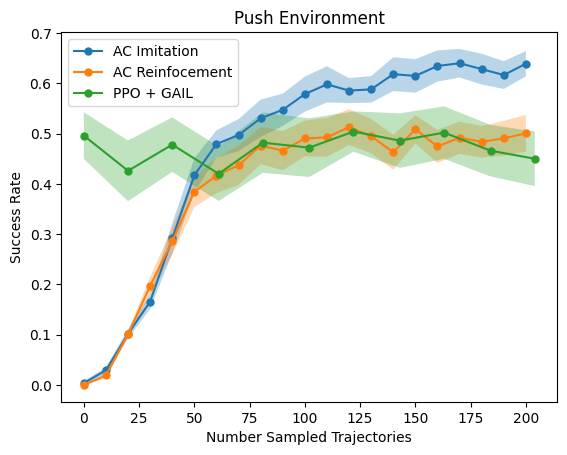

In [22]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-23'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/'


include_ac = ['push', '20','True', 'stats', '2000']
exclude_ac = ['optimize']

include_ac2 = ['push', '20','False', 'stats', '2000']
exclude_ac2 = ['optimize']

include_bl = ['demonstrations_20', 'learner', 'push', 'PPO', '0.0001']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, AC_path, bl_path], 
    includes=[include_ac, include_ac2, include_bl], 
    excludes=[exclude_ac, exclude_ac2, []],
    names=['AC Imitation', 'AC Reinfocement', 'PPO + GAIL'],
    plot_name='Push Environment',
    save_path = None
    )

for path: /home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-23: 10
for path: /home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-23: 10
for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/: 10
for path: /home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/: 10


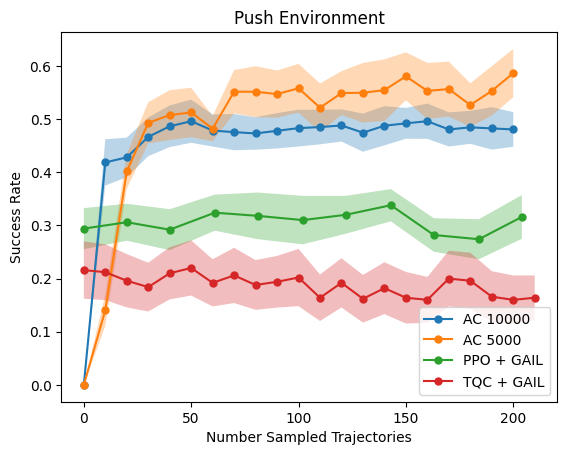

In [1]:
from active_critic.analyze_stats.push_TQC_PPO_GAIL_5000_10000 import run_exp
run_exp()

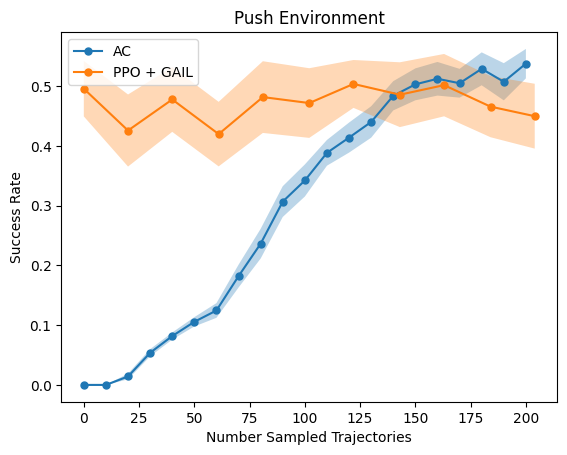

In [11]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-22_val_1000'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/'

include_ac = ['push', '20','True', 'stats']
exclude_ac = ['optimize']

include_bl = ['demonstrations_20', 'learner', 'push', 'PPO', '0.0001']
exclude_bl = []


save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, bl_path], 
    includes=[include_ac, include_bl], 
    excludes=[exclude_ac, exclude_bl],
    names=['AC', 'PPO + GAIL'],
    plot_name='Push Environment',
    save_path = None
    )

In [6]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_2023-02-22/'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-22/'

include_ac1 = ['push', '15','False', 'stats']
exclude_ac1 = ['optimize']

include_ac2 = ['push', '15','True', 'stats']
exclude_ac2 = ['optimize']

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[AC_path, AC_path], 
    includes=[include_ac1, include_ac2], 
    excludes=[exclude_ac1, []],
    names=['AC', 'AC Imitation'],
    plot_name='Push Environment',
    save_path = None
    )

KeyError: 'step'

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_test_2023-02-21'
bl_path = '/home/hendrik/Documents/master_project/LokalData/server/baselines/Baselines_Stats_GAIL_2023-02-21'

include_ac = ['pickplace demonstrations: 6, im_ph:False', 'stats']
exclude_ac = ['optimize']

include_bl14 = ['demonstrations_14', 'learner', 'push', 'PPO']
exclude_bl = []

include_bl10 = ['demonstrations_10', 'learner', 'push', 'PPO']
exclude_bl = []

include_bl6 = ['demonstrations_6', 'learner', 'push', 'TQC', 'id_0']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/Push 6/'

make_plot(
    paths=[bl_path, bl_path, bl_path], 
    includes=[include_bl14, include_bl10, include_bl6], 
    excludes=[exclude_bl, exclude_bl, exclude_bl],
    names=['14', '10', '6'],
    plot_name='Push Environment',
    save_path = save_path
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/pickplace 14/AC/'
PPOGail = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/pickplace 14/PPO GAIL'
TQCPath = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/pickplace 14/TQC GAIL'

include_ac = ['stats']
exclude_ac = []

include_PPOGail = ['learner']
exclude_bl = []

include_TQC = ['learner']
exclude_bl = []

save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/PickPlace_14/'

make_plot(
    paths=[AC_path, PPOGail, TQCPath], 
    includes=[include_ac, include_PPOGail, include_TQC], 
    excludes=[exclude_ac, exclude_bl, exclude_bl],
    names=['AC', 'PPO + GAIL', 'TQC + GAIL'],
    plot_name='Pick and Place Environment',
    save_path = save_path
    )

In [ ]:
AC_path = '/home/hendrik/Documents/master_project/LokalData/server/AC/AC_var_test_2023-02-21'

include_ac = ['stats', 'window', '6']
exclude_ac = ['optimize']


save_path = '/home/hendrik/Documents/master_project/LokalData/server/Stats for MA/PickPlace_14/'

make_plot(
    paths=[AC_path], 
    includes=[include_ac], 
    excludes=[exclude_ac, exclude_bl, exclude_bl],
    names=['AC'],
    plot_name='Reach Environment',
    save_path = None
    )